# Discrete sampling
In the last problem of the first session we sampled with given probabilities using prefix sums and binary search. The sampling code is the bottleneck of the whole process, its running times is 3 times higher than the code for uniform probabilities, and the difference would only increase for larger number of outcomes. In the next two problems we discuss two simple, but powerful techniques one can use to sample in time $O(1)$.

**Problem 2a.** Consider the problem of sampling with known probabilities $p_1,\ldots,p_d$. Suppose that you have a black-box that samples with probabilities $q_1,\ldots,q_d$ that are close to $p_1,\ldots,p_d$, say
$$ \forall_{i=1,\ldots,n} p_i \le (1+\varepsilon)q_i.$$

* How can you use this black-box to sample with probabilities $p_1,\ldots,p_d$? It is expected, that the running time of the algorithm would be non-deterministic.
* Prove that your algorithm is correct.
* Implement the algorithm and use it to give a faster implementation for **Problem 1c**.

(9810669,)


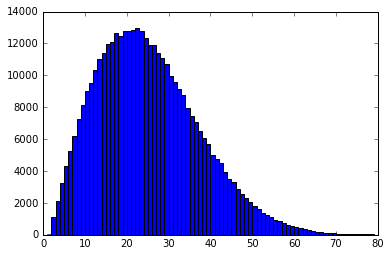

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

T = np.loadtxt('us_births_69_88.csv', skiprows=1, delimiter=',', dtype=int)

total = np.sum(T[:, 2])

prob = T[:, 2] / total

highest = np.max(prob)


days = np.random.randint(371, size = 10000000)

def accept(i):
    los = random.uniform(0, highest)
    return los < prob[days[i]]

accepts = np.fromfunction(accept, days.shape, dtype=int)

final_days = days[accepts]

print (final_days.shape)

def random_dates():
    results = []
    s = set()
    counter = 0
    
    for day in final_days:
        counter += 1
        if day in s:
            results.append(counter)
            s.clear()
            counter = 0
        else:
            s.add(day)
            
    return results


plt.hist(random_dates(), bins=range(1, 80))
plt.show()

   


**Problem 2b.** One of the reasons this implementation is not significantly faster than the one in **Problem 1c** , apart from $d$ being rather small, is that we are using Python's interpreter a bit too much, and Python is slow. One way around this is usually to use a library function - **searchsorted** is much faster than an equivalent code implemented in pure Python. But even if the functionality you need is not implemented in a lower level language as
a library function, there is still hope. You can try to implement it using optimized array algebra, for example using **numpy**. In this problem, your task is to rewrite the previous algorithm, so that the amount of *looping* is reduced to a minimum necessary. In particular, you should create a *vectorized* version of random dates generation (in bulk), while the actual search for duplicates remains a loop with a **set**. Here are some useful tips:
   * You can perform arithmetic, comparisons, etc. on **numpy** arrays.
   * You can generate whole **numpy** arrays of random numbers at once.
   * You can even perform parallel look-up like in the example below.

In [ ]:
X = np.array([10,3,7])
I = np.array([1,1,2,2])
print(X[I])
X = np.array([[1,2],[3,4]])
I = np.array([0,0,1])
J = np.array([1,0,1])
print(X[I,J])

**Problem 2c (Squaring the histogram).** In this problem, we again want to sample with known probabilities $p_1,\ldots,p_n$, but this time we make no assumptions on $p_i$. Consider the following algorithm:
   * Let $V$ be the mean of $p_i$, i.e. $M=\frac{1}{n}$.
   * Create $n$ buckets, each with volume $V$, put each $p_i$ into a separate bucket.
   * Until there exists a bucket $A$ that is not full, find a bucket $B$ that overflows, and trasfer probability from $B$ to $A$ until $A$ is exactly full

Show that:
   * This algorithm always ends.
   * When it ends, each bucket contains pieces of exactly two $p_i$'s.

How to use the result of this algorithm to sample with probabilities $p_i$. Argue that your algorithm is correct and implement it. The sampling part should be *vectorized*. Use this algorithm to sample birthdates again, and test its efficiency.

** Justification of the solution for the problem 2c **

In each of the steps, we entirely fit one bucket - we can do it as we transfer the content from a one which overflows. In a single step, we may change a bucket that overflows into one that is not full. However, after each step the number of buckets that are considered is lower. Therefore an algorithms is finite, more exactly it requires $O(n)$ operations for the phase of preprocessing, then the sampling is also in linear time, considering the sample size.

Each bucket contains pieces of one or two $pi$'s - bucket $A_i$ contains $p_i$ and one other if we actually filled it (we always fill the bucket once - up to the top).

*Michał Kuźba*

[5 5 2 4 5 0 5 0 5 5 1 1 0 2 0 5 0 5 5 0 1 5 0 0 0 5 5 5 1 5]


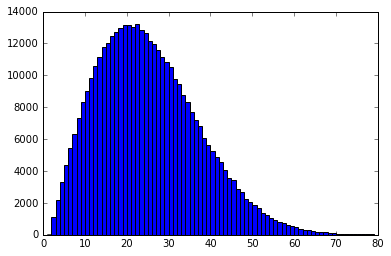

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

class Randomizer:
    over = []
    under = []        
    
    """ Init randomizer with a given probabilities. """
    def __init__(self, p):
        self.p = np.array(p)
        self.avg = np.mean(self.p)
        self.buckets = np.zeros((self.p.shape[0], 2), dtype=int)
        self.threshold = np.full((self.p.shape[0],), self.avg)
        self.buckets[::, 0] = np.arange(self.p.shape[0])
        self.__fill()
     
    """ Sample with a given probabilities. """
    def sample(self, size):
        indexes = np.random.randint(0, self.p.shape[0], size=size)
        positions = np.random.uniform(0, self.avg, size=size)
        masks = positions < self.threshold[indexes]
        return np.where(masks, self.buckets[::, 0][indexes], self.buckets[::, 1][indexes])
        
    
    """ Fill the buckets"""
    def __fill(self):
        for i in range(self.p.shape[0]):
            if self.p[i] < self.avg:
                self.under.append(i)
            elif self.p[i] > self.avg:
                self.over.append(i)
        
        while len(self.under) > 0:
            un = self.under.pop()
            ov = self.over.pop()
                        
            self.threshold[un] = self.p[un]
            self.buckets[un, 1] = ov
            
            # subtract the part we borrowed
            self.p[ov] -= (self.avg - self.p[un])
            
            # Floats inequality
            if not np.isclose(self.p[ov], self.avg):
                if self.p[ov] < self.avg:
                    self.under.append(ov)
                elif self.p[ov] > self.avg:
                    self.over.append(ov)       
                         
    def print_buckets(self):
        print(self.buckets)
        print(self.threshold)
        
Births = np.loadtxt('us_births_69_88.csv', skiprows=1, delimiter=',', dtype=int)

total = np.sum(Births[:, 2])

prob = Births[:, 2] / total

def test():
    pr = [0.25, 0.1, 0.1, 0.0, 0.05, 0.5]

    ran = Randomizer(pr)

    print(ran.sample(30))

test()

randomizer = Randomizer(prob)

sample = randomizer.sample(10000000)


def random_dates():
    results = []
    s = set()
    counter = 0
    
    for day in sample:
        counter += 1
        if day in s:
            results.append(counter)
            s.clear()
            counter = 0
        else:
            s.add(day)
            
    return results


plt.hist(random_dates(), bins=range(1, 80))
plt.show()
    

**Problem 2d.** Show that the frequency histogram for empirical birthday frequencies can actually be computed exactly, and implement your idea. To this end, design a recurence relation using conditional probabilities and use dynamic programming.